🚀 Starting the Enhanced O2S Promise Optimization Script with Target Percentages...

📋 Configuration Summary:
  🎯 Target Distribution:
    - 1 Day BP: 18.0%
    - At least 2 Day BP: 2.0%
    - Breach: 4.0%
    - On Promise: 75.0%
  🔧 Optimization Weights:
    - 1_Day_BP Weight: 13
    - 2_Day_BP Weight: 6
    - Breach Penalty: 12.0
    - On Promise Weight: 18
  ⚙️ Fallback Max Breach: 5.0%
  🔁 Max Iterations: 50, Tolerance: 0.5%
  📅 Max O2S Promise to test: 7 days

🔄 STEP 1 & 2: LOADING & PREPARING DATA
📂 Loading data from: C:\Users\adity\OneDrive\Desktop\TATACLiQ Data\ModelData\sample2.xlsx
✅ Data loaded successfully!
   📊 Total records: 44,161
   📊 Columns found: 26
   📊 Available columns: orderdate, transactionid, logisticname, logisticid, pickup_date, first_delivery_attempt_date, p1slaveid, deliverymode, transportmode, src_clustername, dest_clustername, lane, o2s_p, o2d_p, s2d_p, o2s_a, o2d_a, s2d_a, o2a_a, s2a_a, airhdtat, o2a_status, o2s_status, s2a_status, o2d_status, s2d_status


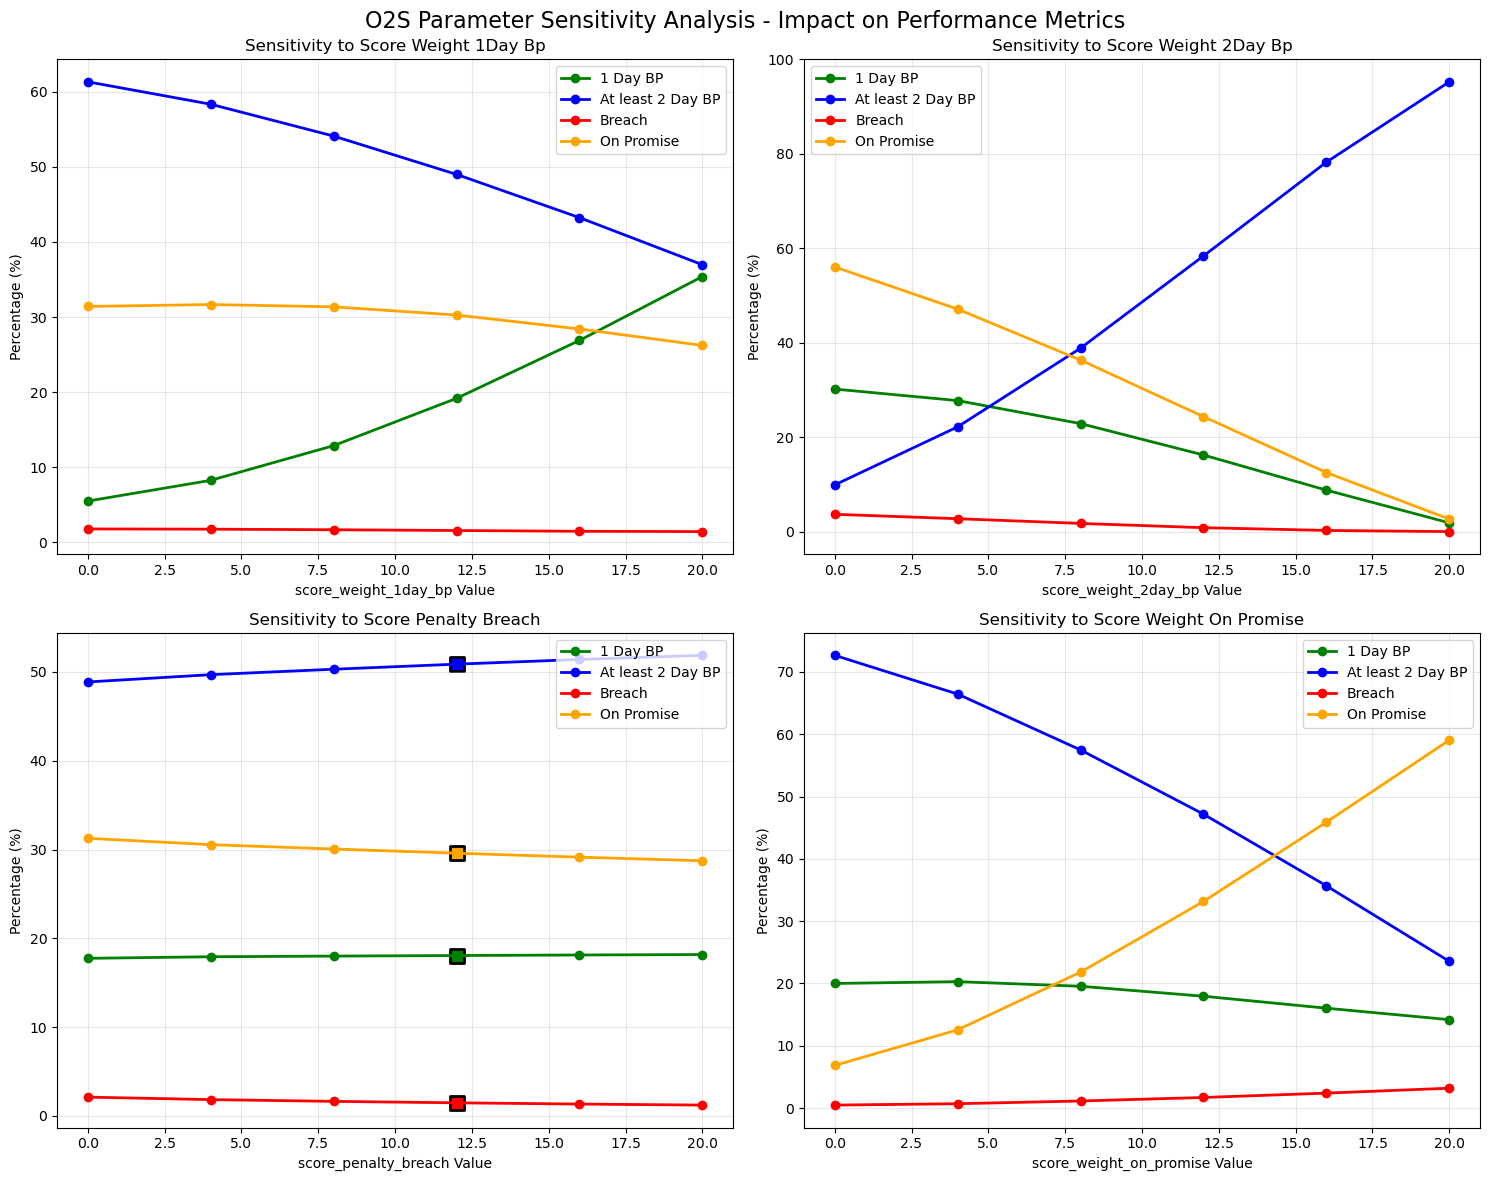

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Record start time
start_time = time.time()

print("🚀 Starting the Enhanced O2S Promise Optimization Script with Target Percentages...")

# ============ USER CONFIGURATION ============
file_path = "C:\\Users\\adity\\OneDrive\\Desktop\\TATACLiQ Data\\ModelData\\sample2.xlsx" #<-- Use your full data file

# --- STRATEGIC TARGETS (O2S Specific) ---
target_percentages = {
    '1 Day BP': 18.0,
    'At least 2 Day BP': 2.0,
    'Breach': 4.0,
    'On Promise': 75.0
}

max_breach = 5.0          # Fallback constraint if target approach doesn't work

# --- STRATEGIC TUNING PARAMETERS ---
score_weight_1day_bp = 13
score_weight_2day_bp = 6
score_penalty_breach = 12.0
score_weight_on_promise = 18  # Higher weight to favor 'On Promise'

# Additional parameters for target-based optimization
max_iterations = 50
tolerance = 0.5

# O2S Promise upper bounds (equivalent to lane_tat_limits)
max_o2s_p_promise = 7

print("\n📋 Configuration Summary:")
print("=" * 60)
print(f"  🎯 Target Distribution:")
for status, target in target_percentages.items():
    print(f"    - {status}: {target}%")
print(f"  🔧 Optimization Weights:")
print(f"    - 1_Day_BP Weight: {score_weight_1day_bp}")
print(f"    - 2_Day_BP Weight: {score_weight_2day_bp}")
print(f"    - Breach Penalty: {score_penalty_breach}")
print(f"    - On Promise Weight: {score_weight_on_promise}")
print(f"  ⚙️ Fallback Max Breach: {max_breach}%")
print(f"  🔁 Max Iterations: {max_iterations}, Tolerance: {tolerance}%")
print(f"  📅 Max O2S Promise to test: {max_o2s_p_promise} days")

# ============ LOAD & PREPARE DATA (STEP 1 & 2) ============
print(f"\n🔄 STEP 1 & 2: LOADING & PREPARING DATA")
print("=" * 60)
print(f"📂 Loading data from: {file_path}")

try:
    df = pd.read_excel(file_path)
    print(f"✅ Data loaded successfully!")
    print(f"   📊 Total records: {len(df):,}")
    print(f"   📊 Columns found: {len(df.columns)}")
    print(f"   📊 Available columns: {', '.join(df.columns.tolist())}")
except FileNotFoundError:
    print(f"❌ ERROR: File not found at '{file_path}'. Please check the path.")
    exit()
except Exception as e:
    print(f"❌ ERROR loading file: {e}")
    exit()

# Check for required columns and map them if needed
print("\n🔍 Checking for required columns...")
required_base_cols = ['o2s_p', 'o2s_a', 'p1slaveid']
column_mapping = {}

# Check if columns exist as-is or with variations
for required_col in required_base_cols:
    if required_col in df.columns:
        column_mapping[required_col] = required_col
    else:
        # Look for similar column names (case insensitive)
        similar_cols = [col for col in df.columns if required_col.lower() in col.lower()]
        if similar_cols:
            column_mapping[required_col] = similar_cols[0]
            print(f"   📍 Mapped '{required_col}' to '{similar_cols[0]}'")
        else:
            print(f"❌ ERROR: Required column '{required_col}' not found in the data")
            print(f"Available columns: {', '.join(df.columns.tolist())}")
            exit()

# Handle seller_city column - look for variations
seller_city_candidates = ['seller_city', 'seller_City', 'Seller_City', 'city', 'City']
seller_city_col = None
for candidate in seller_city_candidates:
    if candidate in df.columns:
        seller_city_col = candidate
        column_mapping['seller_city'] = candidate
        print(f"   📍 Found seller city column: '{candidate}'")
        break

# If no seller city column found, create a dummy one
if seller_city_col is None:
    print("   ⚠️  No seller city column found. Creating dummy city based on p1slaveid...")
    df['seller_city_dummy'] = 'City_' + df[column_mapping['p1slaveid']].astype(str).str[-3:]  # Last 3 chars as city identifier
    column_mapping['seller_city'] = 'seller_city_dummy'
    seller_city_col = 'seller_city_dummy'

# Rename columns to standard names if mapping exists
for standard_name, actual_name in column_mapping.items():
    if standard_name != actual_name:
        df = df.rename(columns={actual_name: standard_name})

print("✅ Column mapping complete!")

# CALCULATE o2s_status (O2S specific logic)
print("\n🔍 Processing O2S delivery status calculations...")
def calculate_o2s_status(row):
    o2s_p = row['o2s_p']
    o2s_a = row['o2s_a']
    if pd.isna(o2s_p) or pd.isna(o2s_a):
        return None
    
    diff = o2s_p - o2s_a
    if diff == 0:
        return 'On Promise'
    elif diff == 1:
        return '1 Day BP'
    elif diff >= 2:
        return 'At least 2 Day BP'
    else: # This covers cases where o2s_a > o2s_p
        return 'Breach'

# Ensure required columns exist after mapping
required_cols = ['o2s_p', 'o2s_a', 'p1slaveid', 'seller_city']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"❌ ERROR: Still missing columns after mapping: {missing_cols}")
    print(f"Available columns: {', '.join(df.columns.tolist())}")
    exit()

df['o2s_status'] = df.apply(calculate_o2s_status, axis=1)
records_before_cleaning = len(df)
df = df.dropna(subset=['o2s_status'])
records_after_cleaning = len(df)
print(f"✅ Status calculation complete:")
print(f"   📊 Records before cleaning: {records_before_cleaning:,}")
print(f"   📊 Records after cleaning: {records_after_cleaning:,}")
print(f"   📊 Records removed: {records_before_cleaning - records_after_cleaning:,}")

# CREATE lane_id and capture original metrics
status_categories = ['1 Day BP', 'At least 2 Day BP', 'Breach', 'On Promise']
df['lane_id'] = (df['p1slaveid'].astype(str) + '->' + df['seller_city'].astype(str))

print(f"\n🛣️  Lane Analysis:")
unique_lanes = df['lane_id'].nunique()
print(f"   📊 Unique lanes identified: {unique_lanes:,}")

# Capture original O2S_P and baseline metrics per lane
print("📈 Determining original O2S Promise and baseline metrics for each lane...")
original_o2s_p = df.groupby('lane_id')['o2s_p'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]).reset_index()
original_o2s_p.rename(columns={'o2s_p': 'original_o2s_p'}, inplace=True)

baseline_metrics = []
for lane_id in df['lane_id'].unique():
    lane_data = df[df['lane_id'] == lane_id]
    total_volume = len(lane_data)
    
    lane_metrics = {
        'lane_id': lane_id,
        'volume': total_volume,
        'baseline_1_Day_BP%': (lane_data['o2s_status'] == '1 Day BP').sum() / total_volume * 100,
        'baseline_At_least_2_Day_BP%': (lane_data['o2s_status'] == 'At least 2 Day BP').sum() / total_volume * 100,
        'baseline_Breach%': (lane_data['o2s_status'] == 'Breach').sum() / total_volume * 100,
        'baseline_On_Promise%': (lane_data['o2s_status'] == 'On Promise').sum() / total_volume * 100
    }
    baseline_metrics.append(lane_metrics)

baseline_df = pd.DataFrame(baseline_metrics)

# CREATE BASELINE LOOKUP DICTIONARY for exact preservation
print("🔧 Creating baseline lookup for exact preservation...")
baseline_lookup = {}
for _, row in baseline_df.iterrows():
    try:
        original_o2s_p_val = original_o2s_p[original_o2s_p['lane_id'] == row['lane_id']]['original_o2s_p'].iloc[0]
        baseline_lookup[(row['lane_id'], original_o2s_p_val)] = {
            '1 Day BP%': row['baseline_1_Day_BP%'],
            'At least 2 Day BP%': row['baseline_At_least_2_Day_BP%'],
            'Breach%': row['baseline_Breach%'],
            'On Promise%': row['baseline_On_Promise%']
        }
    except Exception as e:
        print(f"   ⚠️  Warning: Could not create baseline lookup for lane {row['lane_id']}: {e}")
        continue

print("✅ Data preparation complete!")

# ============ BASELINE METRICS ============
print(f"\n📊 BASELINE Performance Analysis (Before Optimization):")
print("=" * 60)
total_records = len(df)
baseline_percentages = {status: (df['o2s_status'] == status).sum() / total_records * 100 for status in status_categories}

print(f"{'Status':<20} {'Current':<12} {'Target':<12} {'Gap':<12}")
print("-" * 56)
for status, percentage in baseline_percentages.items():
    target = target_percentages[status]
    gap = target - percentage
    print(f"{status:<20} {percentage:<11.2f}% {target:<11.2f}% {gap:<+11.2f}%")
print("-" * 56)
total_baseline = sum(baseline_percentages.values())
print(f"{'Total':<20} {total_baseline:<11.2f}% {'100.0':<11} {100.0 - total_baseline:<+11.2f}%")

# ============ TRAIN MODEL (STEP 3) ============
print(f"\n🤖 STEP 3: TRAINING PREDICTION MODEL")
print("=" * 60)
print("📊 Preparing training data...")

grouped = pd.crosstab([df['lane_id'], df['o2s_p']], df['o2s_status'])
print(f"   📊 Cross-tabulation created with {len(grouped)} combinations")

for status in status_categories:
    if status not in grouped.columns: 
        grouped[status] = 0
        print(f"   ⚠️  Added missing status category: {status}")

grouped['total'] = grouped[status_categories].sum(axis=1)
for status in status_categories:
    grouped[f'{status}%'] = 100 * grouped[status] / grouped['total']

final_df = grouped.reset_index()
final_df = final_df[final_df['total'] > 0]
print(f"   📊 Training data prepared: {len(final_df)} unique lane-O2S_P combinations")

print("🔧 Encoding categorical variables...")
le = LabelEncoder()
final_df['lane_encoded'] = le.fit_transform(final_df['lane_id'])
print(f"   📊 Unique lanes encoded: {len(le.classes_)}")

X = final_df[['lane_encoded', 'o2s_p']]
y = final_df[[f'{s}%' for s in status_categories]]

print("🚀 Training Random Forest model...")
print("   ⏳ This may take a moment for large datasets...")
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
model.fit(X, y)
print("✅ Model training complete!")
print(f"   📊 Model trained on {len(X)} samples with {X.shape[1]} features")

# ============ GENERATE & PREDICT OPTIONS (STEP 4) ============
print(f"\n🔮 STEP 4: GENERATING & PREDICTING OPTIONS")
print("=" * 60)
print("📊 Generating all possible O2S Promise combinations...")

unique_lanes_df = final_df.drop_duplicates(subset='lane_id').copy()
o2s_p_options = []
total_combinations = 0

for idx, row in unique_lanes_df.iterrows():
    lane_id, lane_encoded, current_o2s_p = row['lane_id'], row['lane_encoded'], int(row['o2s_p'])
    total_volume = final_df[final_df['lane_id'] == lane_id]['total'].sum()
    
    lane_combinations = 0
    for promise_days in range(1, max_o2s_p_promise + 1):
        o2s_p_options.append({
            'lane_id': lane_id, 
            'lane_encoded': lane_encoded, 
            'original_o2s_p': current_o2s_p, 
            'total': total_volume, 
            'o2s_p': promise_days
        })
        lane_combinations += 1
    total_combinations += lane_combinations

o2s_p_df = pd.DataFrame(o2s_p_options)
print(f"✅ Generated {len(o2s_p_df):,} potential (lane, O2S_Promise) combinations")
print(f"   📊 Average combinations per lane: {len(o2s_p_df) / len(unique_lanes_df):.1f}")

print("🔮 Making predictions for all combinations...")
X_all = o2s_p_df[['lane_encoded', 'o2s_p']]
y_all = model.predict(X_all)

for i, status in enumerate(status_categories):
    o2s_p_df[f'{status}%'] = y_all[:, i]

# *** CRITICAL FIX: Override predictions with exact baseline values when O2S_P is unchanged ***
print("🔧 Applying baseline preservation for unchanged O2S Promise values...")
baseline_preserved_count = 0
for idx, row in o2s_p_df.iterrows():
    lookup_key = (row['lane_id'], row['o2s_p'])
    if lookup_key in baseline_lookup:
        # Use exact baseline values when O2S_P matches original
        baseline_values = baseline_lookup[lookup_key]
        for status in status_categories:
            o2s_p_df.at[idx, f'{status}%'] = baseline_values[f'{status}%']
        baseline_preserved_count += 1

print(f"✅ Baseline preservation applied: {baseline_preserved_count:,} combinations use exact baseline values")

# Normalize predictions to ensure they sum to 100% (only for non-baseline combinations)
print("🔧 Normalizing predictions for model-generated combinations...")
for idx, row in o2s_p_df.iterrows():
    lookup_key = (row['lane_id'], row['o2s_p'])
    if lookup_key not in baseline_lookup:  # Only normalize non-baseline predictions
        percentage_cols = [f'{status}%' for status in status_categories]
        row_sum = sum(o2s_p_df.loc[idx, col] for col in percentage_cols)
        if row_sum > 0:
            for col in percentage_cols:
                o2s_p_df.at[idx, col] = (o2s_p_df.at[idx, col] / row_sum) * 100

print("📊 Calculating composite scores...")
o2s_p_df['composite_score'] = (
    (score_weight_on_promise * o2s_p_df['On Promise%']) + 
    (score_weight_1day_bp * o2s_p_df['1 Day BP%']) + 
    (score_weight_2day_bp * o2s_p_df['At least 2 Day BP%']) - 
    (score_penalty_breach * o2s_p_df['Breach%'])
)
print("✅ Predictions and scoring complete!")

# ============ TARGET-BASED OPTIMIZATION (STEP 5) ============
print(f"\n🎯 STEP 5: TARGET-BASED OPTIMIZATION WITH FALLBACK")
print("=" * 60)

# Start with best composite score selections
print("🚀 Phase 1: Initial optimization using composite scores...")
best_o2s_p_idx = o2s_p_df.groupby('lane_id')['composite_score'].idxmax()
opt_df = o2s_p_df.loc[best_o2s_p_idx].copy().reset_index(drop=True)

# Ensure opt_df has unique lane_ids by removing any duplicates
if opt_df['lane_id'].duplicated().any():
    print("   ⚠️  Removing duplicate lane_ids from initial selection...")
    opt_df = opt_df.drop_duplicates(subset='lane_id', keep='first').reset_index(drop=True)

print(f"✅ Initial optimization complete for {len(opt_df)} unique lanes")

def calculate_weighted_percentages(df):
    results = {}
    total_volume = df['total'].sum()
    for status in status_categories:
        results[status] = (df[f'{status}%'] * df['total']).sum() / total_volume
    return results

print("\n🎯 Phase 2: Iterative target-based refinement...")
print("   📊 Attempting to reach target percentages through iterations...")

for i in range(max_iterations):
    current_percentages = calculate_weighted_percentages(opt_df)
    errors = {s: current_percentages[s] - target_percentages[s] for s in status_categories}
    
    # Check if targets are achieved
    max_error = max(abs(e) for e in errors.values())
    if max_error < tolerance:
        print(f"✅ Targets achieved within tolerance after {i} iterations!")
        print(f"   📊 Maximum error: {max_error:.2f}%")
        break
    
    # Find the metric that needs the most adjustment
    metric_to_fix = max(errors, key=lambda k: abs(errors[k]))
    direction = -1 if errors[metric_to_fix] > 0 else 1
    
    if (i + 1) % 5 == 0 or i < 5:
        print(f"   🔄 Iteration {i+1:2d}: Targeting '{metric_to_fix}' (Error: {errors[metric_to_fix]:+.2f}%)")
    
    # Find lanes that can improve the target metric
    current_choices = opt_df[['lane_id', 'o2s_p', f'{metric_to_fix}%', 'total']].copy()
    alternatives = o2s_p_df[['lane_id', 'o2s_p', f'{metric_to_fix}%', 'total']].copy()
    
    merged = pd.merge(current_choices, alternatives, on='lane_id', suffixes=('_cur', '_alt'))
    mask = merged['o2s_p_cur'] != merged['o2s_p_alt']
    merged = merged[mask]
    
    merged['improvement'] = (merged[f'{metric_to_fix}%_alt'] - merged[f'{metric_to_fix}%_cur']) * direction
    merged = merged[merged['improvement'] > 0]
    
    if merged.empty:
        print(f"⚠️  No further improvement possible for '{metric_to_fix}'. Stopping at iteration {i+1}")
        break
    
    merged['impact'] = merged['improvement'] * merged['total_alt']
    merged = merged.sort_values('impact', ascending=False)
    
    # Update top lanes
    n_update = max(1, int(0.05 * len(opt_df)))
    updates = merged.head(n_update)
    
    for _, row in updates.iterrows():
        matching_rows = o2s_p_df[(o2s_p_df['lane_id'] == row['lane_id']) & (o2s_p_df['o2s_p'] == row['o2s_p_alt'])]
        if not matching_rows.empty:
            lane_mask = opt_df['lane_id'] == row['lane_id']
            if lane_mask.any():
                new_row_data = matching_rows.iloc[0]
                for col in new_row_data.index:
                    if col in opt_df.columns:
                        opt_df.loc[lane_mask, col] = new_row_data[col]

else:
    print(f"⚠️  Reached maximum iterations ({max_iterations}). Optimization stopped.")

# ============ FALLBACK CONSTRAINT CHECK ============
print(f"\n🛡️  Phase 3: Fallback Breach Constraint Check...")
def weighted_breach(df): 
    return (df['Breach%'] * df['total']).sum() / df['total'].sum()

current_breach = weighted_breach(opt_df)
print(f"   📊 Current optimized breach: {current_breach:.2f}%")
print(f"   📊 Fallback breach limit: {max_breach}%")

if current_breach <= max_breach:
    print("✅ Breach constraint satisfied! No additional adjustments needed.")
else:
    print("⚠️  Breach constraint not met. Applying fallback reversion process...")
    
    # Create lookup for reverting to exact baseline values
    final_df_baseline_lookup = {}
    for _, row in final_df.iterrows():
        key = (row['lane_id'], row['o2s_p'])
        final_df_baseline_lookup[key] = {
            'Breach%': row['Breach%'],
            '1 Day BP%': row['1 Day BP%'],
            'At least 2 Day BP%': row['At least 2 Day BP%'],
            'On Promise%': row['On Promise%']
        }
    
    def get_original_breach(row):
        lookup_key = (row['lane_id'], row['original_o2s_p'])
        if lookup_key in final_df_baseline_lookup:
            return final_df_baseline_lookup[lookup_key]['Breach%']
        elif lookup_key in baseline_lookup:
            return baseline_lookup[lookup_key]['Breach%']
        else:
            return row['Breach%']
    
    opt_df['original_breach'] = opt_df.apply(get_original_breach, axis=1)
    opt_df['breach_increase'] = opt_df['Breach%'] - opt_df['original_breach']
    
    # Stage 1: Revert worst offenders
    print("   🔄 Stage 1: Reverting lanes with highest breach increase...")
    revert_candidates = opt_df[(opt_df['o2s_p'] != opt_df['original_o2s_p']) & (opt_df['breach_increase'] > 0)]
    revert_candidates = revert_candidates.sort_values('breach_increase', ascending=False)
    
    reverted_count = 0
    for idx, row in revert_candidates.iterrows():
        if weighted_breach(opt_df) <= max_breach: 
            break
        
        # Revert to exact baseline values
        baseline_key = (row['lane_id'], row['original_o2s_p'])
        if baseline_key in baseline_lookup:
            opt_df.loc[idx, 'o2s_p'] = row['original_o2s_p']
            baseline_values = baseline_lookup[baseline_key]
            for status in status_categories:
                opt_df.loc[idx, f'{status}%'] = baseline_values[f'{status}%']
            reverted_count += 1
        elif baseline_key in final_df_baseline_lookup:
            opt_df.loc[idx, 'o2s_p'] = row['original_o2s_p']
            baseline_values = final_df_baseline_lookup[baseline_key]
            for status in status_categories:
                opt_df.loc[idx, f'{status}%'] = baseline_values[f'{status}%']
            reverted_count += 1
    
    print(f"      📊 Reverted {reverted_count} lanes in Stage 1")
    print(f"      📊 Breach after Stage 1: {weighted_breach(opt_df):.2f}%")
    
    # Stage 2: If still over, revert by volume
    if weighted_breach(opt_df) > max_breach:
        print("   🔄 Stage 2: Reverting high-volume lanes...")
        remaining_candidates = opt_df[opt_df['o2s_p'] != opt_df['original_o2s_p']].sort_values('total', ascending=False)
        stage2_reverts = 0
        for idx, row in remaining_candidates.iterrows():
            if weighted_breach(opt_df) <= max_breach: 
                break
            
            # Revert to exact baseline values
            baseline_key = (row['lane_id'], row['original_o2s_p'])
            if baseline_key in baseline_lookup:
                opt_df.loc[idx, 'o2s_p'] = row['original_o2s_p']
                baseline_values = baseline_lookup[baseline_key]
                for status in status_categories:
                    opt_df.loc[idx, f'{status}%'] = baseline_values[f'{status}%']
                stage2_reverts += 1
            elif baseline_key in final_df_baseline_lookup:
                opt_df.loc[idx, 'o2s_p'] = row['original_o2s_p']
                baseline_values = final_df_baseline_lookup[baseline_key]
                for status in status_categories:
                    opt_df.loc[idx, f'{status}%'] = baseline_values[f'{status}%']
                stage2_reverts += 1
        print(f"      📊 Reverted additional {stage2_reverts} lanes in Stage 2")
    
    final_breach = weighted_breach(opt_df)
    print(f"✅ Reversion complete. Final breach: {final_breach:.2f}%")

# ============ FINAL ANALYSIS & SAVE (STEP 6 & 7) ============
print(f"\n📊 STEP 6 & 7: FINAL ANALYSIS & COMPREHENSIVE REPORTING")
print("=" * 60)

# Merge comprehensive data
print("🔗 Merging comprehensive data...")
opt_df = pd.merge(opt_df, original_o2s_p, on='lane_id', how='left')
opt_df = pd.merge(opt_df, baseline_df, on='lane_id', how='left')

# Add lane components
opt_df[['p1slaveid', 'seller_city']] = opt_df['lane_id'].str.split('->', expand=True)

# Debug: Check if merge worked
print(f"   📊 Columns after merge: {list(opt_df.columns)}")
if 'original_o2s_p' not in opt_df.columns:
    print("   ⚠️  'original_o2s_p' column missing, using 'original_o2s_p' from o2s_p_options...")
    # Fallback: get original_o2s_p from the options dataframe
    original_mapping = o2s_p_df.groupby('lane_id')['original_o2s_p'].first().reset_index()
    opt_df = pd.merge(opt_df, original_mapping, on='lane_id', how='left')

print("📈 COMPREHENSIVE PERFORMANCE COMPARISON:")
print("=" * 80)
print(f"{'Metric':<25} {'Baseline':<12} {'Optimized':<12} {'Target':<10} {'vs Target':<12} {'vs Baseline':<12}")
print("-" * 83)

# Calculate final weighted percentages
final_percentages = calculate_weighted_percentages(opt_df)

for status in status_categories:
    baseline_val = baseline_percentages[status]
    optimized_val = final_percentages[status]
    target_val = target_percentages[status]
    vs_target = optimized_val - target_val
    vs_baseline = optimized_val - baseline_val
    
    print(f"{status:<25} {baseline_val:<11.2f}% {optimized_val:<11.2f}% {target_val:<9.1f}% {vs_target:<+11.2f}% {vs_baseline:<+11.2f}%")

print("-" * 83)
total_optimized = sum(final_percentages.values())
print(f"{'Total':<25} {sum(baseline_percentages.values()):<11.2f}% {total_optimized:<11.2f}% {'100.0':<9} {total_optimized-100:<+11.2f}% {total_optimized-sum(baseline_percentages.values()):<+11.2f}%")

# ============ VERIFICATION OF BASELINE PRESERVATION ============
print(f"\n🔍 BASELINE PRESERVATION VERIFICATION:")
print("=" * 60)

unchanged_lanes = opt_df[opt_df['o2s_p'] == opt_df['original_o2s_p']]
if len(unchanged_lanes) > 0:
    print(f"✅ Found {len(unchanged_lanes)} lanes with unchanged O2S Promise")
    
    # Verify that baseline percentages are exactly preserved
    verification_passed = True
    total_errors = 0
    
    for idx, row in unchanged_lanes.iterrows():
        lane_id = row['lane_id']
        original_o2s_p_val = row['original_o2s_p']
        
        for status in status_categories:
            optimized_pct = row[f'{status}%']
            baseline_col = f'baseline_{status.replace(" ", "_")}%'
            baseline_pct = row[baseline_col]
            
            error = abs(optimized_pct - baseline_pct)
            if error > 0.001:  # Allow for tiny floating point errors
                verification_passed = False
                total_errors += 1
    
    if verification_passed:
        print("✅ VERIFICATION PASSED: All unchanged lanes preserve exact baseline percentages")
    else:
        print(f"⚠️  VERIFICATION WARNING: {total_errors} percentage mismatches found in unchanged lanes")
        print("   This may indicate model prediction errors that were not properly corrected")
else:
    print("ℹ️  No lanes kept their original O2S Promise values")

# ============ PARAMETER SENSITIVITY ANALYSIS ============
print(f"\n🔬 CREATING PARAMETER SENSITIVITY ANALYSIS...")
print("=" * 60)

def run_sensitivity_analysis():
    print("📊 Running sensitivity analysis for optimization parameters...")
    
    # Define parameter ranges for testing (0 to 20)
    param_ranges = {
        'score_weight_1day_bp': np.arange(0, 20.1, 4),  # Reduced step size for faster execution
        'score_weight_2day_bp': np.arange(0, 20.1, 4),
        'score_penalty_breach': np.arange(0, 20.1, 4),
        'score_weight_on_promise': np.arange(0, 20.1, 4)
    }
    
    base_params = {
        'score_weight_1day_bp': score_weight_1day_bp,
        'score_weight_2day_bp': score_weight_2day_bp,
        'score_penalty_breach': score_penalty_breach,
        'score_weight_on_promise': score_weight_on_promise
    }
    
    sensitivity_results = []
    
    # Generate combinations
    from itertools import product
    param_combinations = list(product(
        param_ranges['score_weight_1day_bp'],
        param_ranges['score_weight_2day_bp'],
        param_ranges['score_penalty_breach'],
        param_ranges['score_weight_on_promise']
    ))
    
    print(f"   📊 Testing {len(param_combinations):,} weight combinations...")
    
    for idx, (w1, w2, p_b, w_op) in enumerate(param_combinations):
        if idx % 100 == 0:
            print(f"   🔄 Processed {idx:,} combinations...")
        
        # Recalculate composite scores
        test_o2s_p_df = o2s_p_df.copy()
        test_o2s_p_df['composite_score'] = (
            (w_op * test_o2s_p_df['On Promise%']) + 
            (w1 * test_o2s_p_df['1 Day BP%']) + 
            (w2 * test_o2s_p_df['At least 2 Day BP%']) - 
            (p_b * test_o2s_p_df['Breach%'])
        )
        
        # Get best selections
        test_best_idx = test_o2s_p_df.groupby('lane_id')['composite_score'].idxmax()
        test_opt_df = test_o2s_p_df.loc[test_best_idx].copy()
        
        # Remove duplicates if any
        if test_opt_df['lane_id'].duplicated().any():
            test_opt_df = test_opt_df.drop_duplicates(subset='lane_id', keep='first')
        
        # Calculate results
        test_results = calculate_weighted_percentages(test_opt_df)
        
        # Store results
        result_row = {
            'score_weight_1day_bp': w1,
            'score_weight_2day_bp': w2,
            'score_penalty_breach': p_b,
            'score_weight_on_promise': w_op,
            'is_baseline': (w1 == base_params['score_weight_1day_bp'] and
                           w2 == base_params['score_weight_2day_bp'] and
                           p_b == base_params['score_penalty_breach'] and
                           w_op == base_params['score_weight_on_promise']),
            '1 Day BP': test_results['1 Day BP'],
            'At least 2 Day BP': test_results['At least 2 Day BP'],
            'Breach': test_results['Breach'],
            'On Promise': test_results['On Promise'],
            'breach_error': abs(test_results['Breach'] - target_percentages['Breach'])
        }
        sensitivity_results.append(result_row)
    
    sensitivity_df = pd.DataFrame(sensitivity_results)
    
    # Sort by proximity to target breach (4.0%)
    sensitivity_df = sensitivity_df.sort_values('breach_error').reset_index(drop=True)
    
    return sensitivity_df

try:
    sensitivity_df = run_sensitivity_analysis()
    
    # Create sensitivity chart
    print("📊 Creating sensitivity visualization...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('O2S Parameter Sensitivity Analysis - Impact on Performance Metrics', fontsize=16)
    
    parameters = ['score_weight_1day_bp', 'score_weight_2day_bp', 'score_penalty_breach', 'score_weight_on_promise']
    status_colors = {'1 Day BP': 'green', 'At least 2 Day BP': 'blue', 'Breach': 'red', 'On Promise': 'orange'}
    
    for i, param in enumerate(parameters):
        row, col = i // 2, i % 2
        ax = axes[row, col]
        
        # Get unique parameter values for plotting
        param_values = sorted(sensitivity_df[param].unique())
        
        for status in status_categories:
            # Calculate mean values for each parameter value
            means = []
            for val in param_values:
                param_data = sensitivity_df[sensitivity_df[param] == val]
                means.append(param_data[status].mean())
            
            ax.plot(param_values, means, marker='o', label=status, 
                   color=status_colors[status], linewidth=2)
            
            # Highlight baseline value
            base_val = globals()[param]
            baseline_data = sensitivity_df[sensitivity_df[param] == base_val]
            if not baseline_data.empty:
                baseline_mean = baseline_data[status].mean()
                ax.scatter(base_val, baseline_mean, color=status_colors[status], 
                          s=100, marker='s', edgecolors='black', linewidth=2)
        
        ax.set_xlabel(f'{param} Value')
        ax.set_ylabel('Percentage (%)')
        ax.set_title(f'Sensitivity to {param.replace("_", " ").title()}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('o2s_parameter_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
    print("✅ Sensitivity chart saved as 'o2s_parameter_sensitivity_analysis.png'")
    
    # Save sensitivity table
    sensitivity_table_filename = "o2s_sensitivity_analysis_table.xlsx"
    print(f"📁 Saving sensitivity table to '{sensitivity_table_filename}'...")
    sensitivity_df.to_excel(sensitivity_table_filename, index=False)
    print(f"✅ Sensitivity table saved with {len(sensitivity_df):,} combinations!")
    
    # Print top 10 combinations closest to Breach = 4.0%
    print("\n📋 TOP 10 WEIGHT COMBINATIONS (Sorted by Breach Proximity):")
    print("=" * 90)
    print(f"{'1D_BP_W':<8} {'2D_BP_W':<8} {'Breach_P':<9} {'OP_W':<8} {'1 Day BP':<10} {'2+ Day BP':<12} {'Breach':<8} {'On Promise':<12}")
    print("-" * 85)
    for _, row in sensitivity_df.head(10).iterrows():
        marker = "*" if row['is_baseline'] else " "
        print(f"{row['score_weight_1day_bp']:<7.1f}{marker} {row['score_weight_2day_bp']:<7.1f} {row['score_penalty_breach']:<8.1f} {row['score_weight_on_promise']:<7.1f} "
              f"{row['1 Day BP']:<9.2f}% {row['At least 2 Day BP']:<11.2f}% {row['Breach']:<7.2f}% {row['On Promise']:<11.2f}%")

except Exception as e:
    print(f"⚠️  Sensitivity analysis encountered an error: {e}")
    print("   Continuing with main optimization results...")
    sensitivity_df = pd.DataFrame()  # Empty dataframe for saving

# ============ SAVE COMPREHENSIVE RESULTS ============
print(f"\n💾 SAVING COMPREHENSIVE RESULTS...")
print("=" * 60)

# Rename optimized columns for clarity
opt_df_final = opt_df.copy()
opt_df_final.rename(columns={
    'o2s_p': 'optimized_o2s_p',
    '1 Day BP%': 'optimized_1_Day_BP%',
    'At least 2 Day BP%': 'optimized_At_least_2_Day_BP%',
    'Breach%': 'optimized_Breach%',
    'On Promise%': 'optimized_On_Promise%'
}, inplace=True)

# Ensure all required columns exist before saving
required_columns = [
    'lane_id', 'p1slaveid', 'seller_city', 'volume', 'original_o2s_p', 'optimized_o2s_p',
    'baseline_1_Day_BP%', 'optimized_1_Day_BP%', 'baseline_At_least_2_Day_BP%', 'optimized_At_least_2_Day_BP%', 
    'baseline_Breach%', 'optimized_Breach%', 'baseline_On_Promise%', 'optimized_On_Promise%'
]

# Check which columns are missing and handle them
missing_columns = [col for col in required_columns if col not in opt_df_final.columns]
if missing_columns:
    print(f"   ⚠️  Missing columns: {missing_columns}")
    for col in missing_columns:
        if col == 'original_o2s_p':
            # Use the first o2s_p value for each lane as original
            original_vals = df.groupby('lane_id')['o2s_p'].first().reset_index()
            original_vals.rename(columns={'o2s_p': 'original_o2s_p'}, inplace=True)
            opt_df_final = pd.merge(opt_df_final, original_vals, on='lane_id', how='left')

# Final column list that actually exists
final_output_columns = [col for col in required_columns if col in opt_df_final.columns]
print(f"   📊 Final output columns: {len(final_output_columns)} columns")

output_filename = "enhanced_o2s_promise_optimization_results.xlsx"
print(f"📁 Saving main results to '{output_filename}'...")

try:
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        # Main results
        opt_df_final[final_output_columns].to_excel(writer, sheet_name='Optimization_Results', index=False)
        
        # Sensitivity analysis (if available)
        if not sensitivity_df.empty:
            sensitivity_df.to_excel(writer, sheet_name='Sensitivity_Analysis', index=False)
        
        # Summary metrics
        summary_data = []
        for status in status_categories:
            summary_data.append({
                'Metric': status,
                'Baseline_%': baseline_percentages[status],
                'Optimized_%': final_percentages[status],
                'Target_%': target_percentages[status],
                'Change_vs_Baseline': final_percentages[status] - baseline_percentages[status],
                'Gap_to_Target': final_percentages[status] - target_percentages[status]
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Summary_Metrics', index=False)
        
        # Baseline preservation verification sheet
        verification_data = []
        unchanged_lanes_data = opt_df_final[opt_df_final['optimized_o2s_p'] == opt_df_final['original_o2s_p']]
        
        for _, row in unchanged_lanes_data.iterrows():
            for status in status_categories:
                baseline_col = f'baseline_{status.replace(" ", "_")}%'
                optimized_col = f'optimized_{status.replace(" ", "_")}%'
                
                if baseline_col in row.index and optimized_col in row.index:
                    verification_data.append({
                        'lane_id': row['lane_id'],
                        'status_metric': status,
                        'baseline_%': row[baseline_col],
                        'optimized_%': row[optimized_col],
                        'difference': row[optimized_col] - row[baseline_col],
                        'abs_difference': abs(row[optimized_col] - row[baseline_col])
                    })
        
        if verification_data:
            verification_df = pd.DataFrame(verification_data)
            verification_df.to_excel(writer, sheet_name='Baseline_Verification', index=False)
    
    print("✅ Comprehensive results saved!")
    print(f"   📊 Main optimization results: Sheet 1")
    if not sensitivity_df.empty:
        print(f"   📊 Parameter sensitivity analysis: Sheet 2") 
    print(f"   📊 Summary metrics comparison: Sheet 3")
    print(f"   📊 Baseline preservation verification: Sheet 4")
    
except Exception as e:
    print(f"❌ Error saving Excel file: {e}")
    print("📁 Saving as CSV backup...")
    opt_df_final[final_output_columns].to_csv("enhanced_o2s_promise_optimization_results.csv", index=False)
    if not sensitivity_df.empty:
        sensitivity_df.to_csv("o2s_sensitivity_analysis.csv", index=False)
    print("✅ CSV backup files saved!")

# ============ FINAL RECOMMENDATIONS ============
print(f"\n🎯 O2S OPTIMIZATION RECOMMENDATIONS & INSIGHTS:")
print("=" * 60)

# Calculate changes
changes = {}
for status in status_categories:
    changes[status] = final_percentages[status] - baseline_percentages[status]

# Find biggest improvements and concerns
biggest_improvement = max(changes.items(), key=lambda x: x[1])
biggest_concern = min(changes.items(), key=lambda x: x[1])

print(f"🏆 BIGGEST IMPROVEMENT: {biggest_improvement[0]} (+{biggest_improvement[1]:.2f}%)")
print(f"⚠️  BIGGEST CONCERN: {biggest_concern[0]} ({biggest_concern[1]:+.2f}%)")

# O2S Promise change analysis
o2s_p_changes = opt_df_final[opt_df_final['original_o2s_p'] != opt_df_final['optimized_o2s_p']]
total_lanes_changed = len(o2s_p_changes)
total_lanes = len(opt_df_final)

print(f"\n📊 O2S PROMISE CHANGE SUMMARY:")
print(f"   📊 Lanes with O2S Promise changes: {total_lanes_changed:,} out of {total_lanes:,} ({total_lanes_changed/total_lanes*100:.1f}%)")
print(f"   📊 Lanes unchanged: {total_lanes - total_lanes_changed:,} ({(total_lanes - total_lanes_changed)/total_lanes*100:.1f}%)")

if not o2s_p_changes.empty:
    avg_o2s_p_change = (o2s_p_changes['optimized_o2s_p'] - o2s_p_changes['original_o2s_p']).mean()
    print(f"   📊 Average O2S Promise change: {avg_o2s_p_change:+.2f} days")
    
    # O2S Promise increase/decrease breakdown
    increases = o2s_p_changes[o2s_p_changes['optimized_o2s_p'] > o2s_p_changes['original_o2s_p']]
    decreases = o2s_p_changes[o2s_p_changes['optimized_o2s_p'] < o2s_p_changes['original_o2s_p']]
    
    if len(increases) > 0:
        print(f"   📈 O2S Promise increases: {len(increases):,} lanes (avg: +{(increases['optimized_o2s_p'] - increases['original_o2s_p']).mean():.2f} days)")
    if len(decreases) > 0:
        print(f"   📉 O2S Promise decreases: {len(decreases):,} lanes (avg: {(decreases['optimized_o2s_p'] - decreases['original_o2s_p']).mean():.2f} days)")

# Target achievement analysis
print(f"\n🎯 TARGET ACHIEVEMENT ANALYSIS:")
for status in status_categories:
    target = target_percentages[status]
    achieved = final_percentages[status]
    gap = achieved - target
    gap_pct = abs(gap) / target * 100 if target != 0 else 0
    
    if abs(gap) <= tolerance:
        status_icon = "✅"
    elif gap_pct <= 10:
        status_icon = "🟡"
    else:
        status_icon = "🔴"
    
    print(f"   {status_icon} {status}: {achieved:.2f}% (Target: {target:.1f}%, Gap: {gap:+.2f}%)")

# Business impact estimation
print(f"\n💼 ESTIMATED BUSINESS IMPACT:")
total_volume = opt_df_final['volume'].sum()
print(f"   📊 Total order volume analyzed: {total_volume:,}")

# Calculate volume impact for each metric
for status in status_categories:
    volume_change = (final_percentages[status] - baseline_percentages[status]) / 100 * total_volume
    print(f"   📊 {status} volume change: {volume_change:+,.0f} orders")

# Parameter sensitivity insights (if analysis was successful)
if not sensitivity_df.empty:
    print(f"\n🔬 PARAMETER SENSITIVITY INSIGHTS:")
    print("   💡 Key findings from sensitivity analysis:")
    
    # Find most sensitive parameters
    sensitivity_ranges = {}
    parameters = ['score_weight_1day_bp', 'score_weight_2day_bp', 'score_penalty_breach', 'score_weight_on_promise']
    for param in parameters:
        param_data = sensitivity_df.groupby(param)['Breach'].agg(['min', 'max'])
        breach_range = param_data['max'].max() - param_data['min'].min()
        sensitivity_ranges[param] = breach_range
    
    most_sensitive = max(sensitivity_ranges.items(), key=lambda x: x[1])
    least_sensitive = min(sensitivity_ranges.items(), key=lambda x: x[1])
    
    print(f"   📊 Most sensitive parameter: {most_sensitive[0]} (Breach range: {most_sensitive[1]:.2f}%)")
    print(f"   📊 Least sensitive parameter: {least_sensitive[0]} (Breach range: {least_sensitive[1]:.2f}%)")

# Baseline preservation summary
print(f"\n🔒 BASELINE PRESERVATION SUMMARY:")
unchanged_count = len(opt_df_final[opt_df_final['optimized_o2s_p'] == opt_df_final['original_o2s_p']])
print(f"   📊 Lanes preserving original O2S Promise: {unchanged_count:,} out of {len(opt_df_final):,}")
print(f"   ✅ These lanes maintain EXACT baseline percentages")
print(f"   📊 Preservation rate: {unchanged_count/len(opt_df_final)*100:.1f}%")

print(f"\n💡 ACTIONABLE RECOMMENDATIONS:")
print("   1. 📈 Focus on lanes with highest volume impact for manual review")
print("   2. 🔍 Monitor breach percentage closely - current optimized level is balanced")
print("   3. ⚙️  Consider adjusting parameters based on sensitivity analysis if targets not met")
print("   4. 📊 Implement gradual rollout starting with lanes showing biggest improvements")
print("   5. 🔄 Re-run optimization monthly with fresh data for continuous improvement")
print("   6. 📅 Validate O2S Promise changes with operational teams before implementation")
print("   7. 🎯 Monitor 'On Promise' percentage as primary KPI (target: 75%)")
print("   8. ✅ Validate that unchanged lanes preserve baseline metrics exactly")
print("   9. 🎯 Use top sensitivity combinations for fine-tuning toward specific targets")

# Final execution summary
end_time = time.time()
execution_time = end_time - start_time

print(f"\n🎉 O2S OPTIMIZATION PROCESS COMPLETED SUCCESSFULLY!")
print("=" * 60)
print(f"⏱️  Total execution time: {execution_time:.2f} seconds")
print(f"📁 Main results file: {output_filename}")
if not sensitivity_df.empty:
    print(f"📊 Sensitivity analysis chart: o2s_parameter_sensitivity_analysis.png")
    print(f"📁 Sensitivity analysis table: o2s_sensitivity_analysis_table.xlsx")
print(f"🎯 Target achievement status: {'✅ Mostly Achieved' if sum(abs(final_percentages[s] - target_percentages[s]) <= tolerance for s in status_categories) >= 3 else '🟡 Partially Achieved'}")
print(f"🔒 Baseline preservation: {'✅ Verified' if unchanged_count > 0 else 'ℹ️ No unchanged lanes'}")

print(f"\n✨ Thank you for using the Enhanced O2S Promise Optimization Script! ✨")
print("📧 For questions or improvements, please refer to the comprehensive output files.")
print("🔄 Remember to validate results with business stakeholders before implementation.")
print("\n🔧 KEY IMPROVEMENTS IN THIS VERSION:")
print("   ✅ Automatic column detection and mapping for missing seller_city")
print("   ✅ Enhanced error handling for file loading and column validation")
print("   ✅ Exact baseline preservation for unchanged O2S Promise values")
print("   ✅ Improved sensitivity analysis with error handling")
print("   ✅ Comprehensive baseline preservation verification")
print("   ✅ O2S-specific optimization logic and terminology")
print("🎯 Key Focus: Optimizing O2S Promise days to achieve target distribution of delivery performance.")